## Twitter Sentiment Analysis using CNNs and LSTMs with GloVe pre-trained word embeddings

In [1]:
import numpy as np
import pandas as pd
import re 

### Loading the Data

In [2]:
data = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)
data.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [3]:
data['Sentiment'].value_counts()

1    790177
0    788435
Name: Sentiment, dtype: int64

### Data Preprocessing

In [4]:
contractions_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "cannot", 
                    "can't've": "cannot have", 
                    "'cause": "because", 
                    "could've": "could have", 
                    "couldn't": "could not", 
                    "couldn't've": "could not have",
                    "didn't": "did not", 
                    "doesn't": "does not", 
                    "don't": "do not", 
                    "hadn't": "had not",  
                    "hadn't've": "had not have", 
                    "hasn't": "has not", 
                    "haven't": "have not", 
                    "he'd": "he would", 
                    "he'd've": "he would have", 
                    "he'll": "he will", 
                    "he'll've": "he will have", 
                    "he's": "he is", 
                    "how'd": "how did", 
                    "how'd'y": "how do you", 
                    "how'll": "how will", 
                    "how's": "how is", 
                    "I'd": "I would", 
                    "I'd've": "I would have", 
                    "I'll": "I will", 
                    "I'll've": "I will have",
                    "I'm": "I am", 
                    "I've": "I have", 
                    "i'd": "i would", 
                    "i'd've": "i would have", 
                    "i'll": "i will", 
                    "i'll've": "i will have",
                    "i'm": "i am", 
                    "i've": "i have", 
                    "isn't": "is not", 
                    "it'd": "it would", 
                    "it'd've": "it would have", 
                    "it'll": "it will", 
                    "it'll've": "it will have",
                    "it's": "it is", 
                    "let's": "let us", 
                    "ma'am": "madam", 
                    "mayn't": "may not", 
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have", 
                    "must've": "must have", 
                    "mustn't": "must not", 
                    "mustn't've": "must not have", 
                    "needn't": "need not", 
                    "needn't've": "need not have",
                    "o'clock": "of the clock", 
                    "oughtn't": "ought not", 
                    "oughtn't've": "ought not have", 
                    "shan't": "shall not",
                    "sha'n't": "shall not", 
                    "shan't've": "shall not have", 
                    "she'd": "she would", 
                    "she'd've": "she would have", 
                    "she'll": "she will", 
                    "she'll've": "she will have", 
                    "she's": "she is", 
                    "should've": "should have", 
                    "shouldn't": "should not", 
                    "shouldn't've": "should not have", 
                    "so've": "so have",
                    "so's": "so as", 
                    "this's": "this is",
                    "that'd": "that would", 
                    "that'd've": "that would have",
                    "that's": "that is", 
                    "there'd": "there would", 
                    "there'd've": "there would have",
                    "there's": "there is", 
                    "here's": "here is",
                    "they'd": "they would", 
                    "they'd've": "they would have", 
                    "they'll": "they will", 
                    "they'll've": "they will have", 
                    "they're": "they are", 
                    "they've": "they have",
                    "to've": "to have", 
                    "wasn't": "was not", 
                    "we'd": "we would", 
                    "we'd've": "we would have", 
                    "we'll": "we will", 
                    "we'll've": "we will have", 
                    "we're": "we are", 
                    "we've": "we have", 
                    "weren't": "were not",
                    "what'll": "what will", 
                    "what'll've": "what will have", 
                    "what're": "what are", 
                    "what's": "what is", 
                    "what've": "what have", 
                    "when's": "when is", 
                    "when've": "when have", 
                    "where'd": "where did", 
                    "where's": "where is", 
                    "where've": "where have", 
                    "who'll": "who will", 
                    "who'll've": "who will have", 
                    "who's": "who is", 
                    "who've": "who have", 
                    "why's": "why is", 
                    "why've": "why have", 
                    "will've": "will have", 
                    "won't": "will not",
                    "won't've": "will not have", 
                    "would've": "would have", 
                    "wouldn't": "would not", 
                    "wouldn't've": "would not have", 
                    "y'all": "you all", 
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would", 
                    "you'd've": "you would have", 
                    "you'll": "you will", 
                    "you'll've": "you will have", 
                    "you're": "you are", 
                    "you've": "you have" }

In [5]:
def expand_contractions(s, contractions_dict=contractions_dict):
    for key in contractions_dict:
        value = contractions_dict[key]
        s = s.replace(key, value)   
    return s

In [6]:
def text_cleaner(s):
        s = str(s)
        s = s.lower()
        s = expand_contractions(s) 
        s = re.sub(r'([a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+)', '', s) # remove emails
        s = re.sub(r'(?:(?:http|https|ftp):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?', '', s, flags=re.MULTILINE) # remove URLs
        s = re.sub(r'(www.[^ ]+)', '', s) # remove websites
        s = re.sub(r'(@[\w_]+)', '', s) # remove @-mention
        s = re.sub(r'([:=;] [oO\-]?[D\)\]\(\]/\\OpP])', '', s) # remove emoticons
        s = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', '', s) # remove hash-tags
        s = re.sub('RT', '', s) # remove retweets
        s = re.sub('[^a-z A-Z]+', '', s) # keeping only text
        return s.strip()

In [7]:
data['clean_text'] = data['SentimentText'].apply(lambda s:text_cleaner(s))
data.head()

,ItemID,Sentiment,SentimentSource,SentimentText,clean_text
0,1,0,Sentiment140,is so sad for my APL frie...,is so sad for my apl friend
1,2,0,Sentiment140,I missed the New Moon trail...,i missed the new moon trailer
2,3,1,Sentiment140,omg its already 7:30 :O,omg its already o
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im sooo im gunna cry i have been at th...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me tt


In [8]:
sentences = data['clean_text'].tolist()
sentences[:3]

['is so sad for my apl friend',
 'i missed the new moon trailer',
 'omg its already  o']

### Build the model

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.optimizers import Adam 

In [10]:
embedding_dim = 200
max_length = 120
trunc_type='post'
padding_type='post'

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [12]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(vocab_size)

361960


In [13]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences[:3])

[[5, 19, 106, 11, 6, 118809, 245], [1, 237, 3, 71, 754, 1217], [217, 66, 188, 409]]


In [14]:
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(padded)

[[    5    19   106 ...     0     0     0]
 [    1   237     3 ...     0     0     0]
 [  217    66   188 ...     0     0     0]
 ...
 [21866   132    38 ...     0     0     0]
 [37418  1975    48 ...     0     0     0]
 [80363     1   109 ...     0     0     0]]


In [15]:
padded.shape

(1578612, 120)

In [16]:
embeddings_index = {};
with open('glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [17]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [18]:
print(len(embeddings_matrix))

361961


### Train the model

In [19]:
from sklearn.model_selection import train_test_split
X = padded
y = data['Sentiment'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    Dropout(0.2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 200)          72392200  
_________________________________________________________________
dropout (Dropout)            (None, 120, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           64064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 72,489,353
Trainable params: 97,153
Non-trainable params: 72,392,200
_______________________________________

In [22]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/10
39466/39466 [==============================] - 3463s 88ms/step - loss: 0.4432 - accuracy: 0.7923 - val_loss: 0.4112 - val_accuracy: 0.8127
Epoch 2/10
39466/39466 [==============================] - 3347s 85ms/step - loss: 0.4179 - accuracy: 0.8066 - val_loss: 0.4077 - val_accuracy: 0.8148
Epoch 3/10
39466/39466 [==============================] - 3001s 76ms/step - loss: 0.4107 - accuracy: 0.8112 - val_loss: 0.4027 - val_accuracy: 0.8168
Epoch 4/10
39466/39466 [==============================] - 3508s 89ms/step - loss: 0.4069 - accuracy: 0.8138 - val_loss: 0.3994 - val_accuracy: 0.8185
Epoch 5/10
39466/39466 [==============================] - 3632s 92ms/step - loss: 0.4044 - accuracy: 0.8148 - val_loss: 0.4000 - val_accuracy: 0.8192
Epoch 6/10
39466/39466 [==============================] - 4161s 105ms/step - loss: 0.4026 - accuracy: 0.8162 - val_loss: 0.3988 - val_accuracy: 0.8195
Epoch 7/10
39466/39466 [==============================] - 4324s 110ms/step - loss: 0.4009 - accurac

### Training vs Validation Accuracy and Loss Plot

<Figure size 432x288 with 0 Axes>

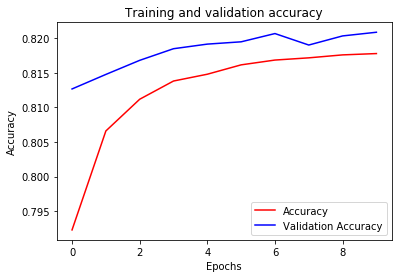

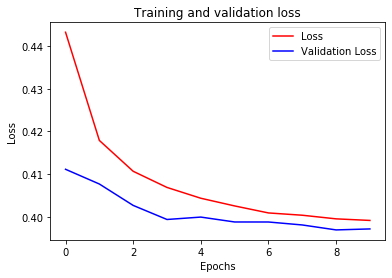

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

### Predicting on Test Data

In [24]:
def text_encoder(s):
    s = text_cleaner(s)
    s = tokenizer.texts_to_sequences([s])
    s = pad_sequences(s, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return s

In [28]:
pred = (model.predict(text_encoder(["It is fun and easy to do sentiment analysis!"])) > 0.5).astype("int32")[0][0]
print("Predicted class is {}.".format(pred))

Predicted class is 1.


In [29]:
pred = (model.predict(text_encoder(["I don't like reading all the negative Tweets!"])) > 0.5).astype("int32")[0][0]
print("Predicted class is {}.".format(pred))

Predicted class is 0.
